# Fort Myers Fire Department: Risk Identification Model

In [40]:
#importing all the libraries and functions we'll need.
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import os
import requests
from tqdm import tnrange, tqdm
from time import sleep
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')
import gmaps
import datetime

import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import matplotlib.pyplot as plt
# %matplotlib inline
import sklearn.externals.six as sksix
import IPython.display as ipd

from sklearn import metrics
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import accuracy_score
import pickle

import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
rc={'font.size': 20, 'axes.labelsize': 20, 'legend.fontsize': 18, 
    'axes.titlesize': 20, 'xtick.labelsize': 18, 'ytick.labelsize': 18}
sns.set(rc=rc)

## Loading & Preparing Datasets

In [3]:
#violations data prep
#all violations datasets
v = pd.read_csv('codecases_violationtype_minimumhousing.csv', names=['Code', 'TimeSpan', 'CaseNum', 'Address', 'Owner', 'STRAP','DateCreated'], header=1)
v1 = pd.read_csv('codecases_violationtype_multifamily.csv', names=['Code', 'TimeSpan', 'CaseNum', 'Address', 'Owner', 'STRAP','DateCreated'], header=1)
v2 = pd.read_csv('codecases_violationtype_permitrequired.csv', names=['Code', 'TimeSpan', 'CaseNum', 'Address', 'Owner', 'STRAP','DateCreated'], header=1)
v3 = pd.read_csv('codecases_violationtype_propertymaintenance.csv', names=['Code', 'TimeSpan', 'CaseNum', 'Address', 'Owner', 'STRAP','DateCreated'], header=1)
v4 = pd.read_csv('codecases_violationtype_unsafestructure.csv', names=['Code', 'TimeSpan', 'CaseNum', 'Address', 'Owner', 'STRAP','DateCreated'], header=1)
v5 = pd.read_csv('codecases_violationtype_vacantbuilding.csv', names=['Code', 'TimeSpan', 'CaseNum', 'Address', 'Owner', 'STRAP','DateCreated'], header=1)

#making a master violations dataframe
violations = pd.concat([v, v1, v2, v3, v4, v5], ignore_index=True)


#formats the violation description to exclude unnessary info
violations.Code = violations.Code.apply(lambda x : x.split(':', 1)[1])

#dropping an irrelevant columns and reformatting the Date
violations.drop(['TimeSpan'], axis=1, inplace=True) #drops irrelevant data column
violations.DateCreated = violations.DateCreated.apply(lambda x: x.strip("Rec'd:   "))

#Renaming columns
violations = violations[['DateCreated', 'Code', 'Address', 'STRAP',]]

#Counting the total violations at each address so we can show the model which buildings have had more violations
violations['total_violations'] = violations.groupby('Address')['Address'].transform('count')

# one-hot encode the types of violations
violations = violations.join(pd.get_dummies(violations['Code'], prefix='Type'))

#giving a violation score to each building out of 10, buildings with more violations have a higher score. 
#this will help later as a feature the model can use to make its predictions. 
violationBuckets = [0,1,2,3,4,5,6,8,12,18,max(violations.total_violations)]
scores = [1,2,3,4,5,6,7,8,9,10]

violations['violationScore'] = pd.cut(violations['total_violations'], violationBuckets, right=True, include_lowest=True, labels=scores)

violations.head()

,DateCreated,Code,Address,STRAP,total_violations,Type_ Minimum Housing,Type_ Multi-Family,Type_ Permit Required,Type_ Property Maintenance,Type_ Site Work/Utilities,Type_ Unsafe,Type_ Vacant Building,violationScore
0,4/29/09,Minimum Housing,2144 DAVIS ST,194425P20140C0120,6,1,0,0,0,0,0,0,6
1,5/8/09,Minimum Housing,715 PINE ST,084425P20280D0100,1,1,0,0,0,0,0,0,1
2,6/10/09,Minimum Housing,8328 SILVER BIRCH WAY,254425P3002000660,1,1,0,0,0,0,0,0,1
3,11/23/09,Minimum Housing,3605 BELL ST,084425P401610009B,4,1,0,0,0,0,0,0,4
4,4/30/10,Minimum Housing,2103 SOUTH ST,244424P4008080020,2,1,0,0,0,0,0,0,2


In [59]:
#Cleaning and prepping the 'CFM' dataset which contains PARCEL DETAILS
cfm = pd.read_csv('CFM_Parcels.csv')

#Excluding columns that are irrelevant
cfm = cfm[['STRAP', 'FolioID','GISAcres', 'FireDistDesc',
       'LandUseCode', 'LandUseDesc','SiteAddress','Just', 'Assessed', 'Taxable', 'NewBuilt', 'BldgCount',
       'MinBuiltYear', 'MaxBuiltYear', 'TotalArea', 'HeatedArea', 'MaxStories',
       'Bedrooms', 'Bathrooms']]

#Renaming the columns so that the Address columns are consistent across datasets
cfm.columns = ['STRAP', 'FolioID','GISAcres', 'FireDistDesc','LandUseCode', 'LandUseDesc',
               'Address','Just', 'Assessed', 'Taxable', 'NewBuilt', 'BldgCount',
               'MinBuiltYear', 'MaxBuiltYear', 'TotalArea', 'HeatedArea', 'MaxStories',
               'Bedrooms', 'Bathrooms']

def oneHot(num): 
    if num > 0: 
        return 1
    else: 
        return 0

cfm.Taxable = cfm.Taxable.apply(lambda x: oneHot(x))
cfm.NewBuilt = cfm.NewBuilt.apply(lambda x: oneHot(x))

cfm = cfm.fillna(0)
cfm['Age'] = int(datetime.datetime.now().year) - ((cfm.MaxBuiltYear + cfm.MinBuiltYear)/2)
cfm['Age'].values[cfm['Age'] > 200] = 0 #some buildings don't have built year data, set them to 0

cfm.head()

,STRAP,FolioID,GISAcres,FireDistDesc,LandUseCode,LandUseDesc,Address,Just,Assessed,Taxable,NewBuilt,BldgCount,MinBuiltYear,MaxBuiltYear,TotalArea,HeatedArea,MaxStories,Bedrooms,Bathrooms,Age
0,014524P1000600000,10186093.0,6.692,CITY OF FORT MYERS,1610.0,"SHOPPING CENTER, NEIGHBORHOOD",4513/4515 S CLEVELAND AVE,3983962.0,3983962.0,1,0,1.0,1976.0,1976.0,65714.0,52598.0,1.0,0.0,0.0,43.0
1,014524P100060001A,10186094.0,0.391,CITY OF FORT MYERS,9530.0,POND,4505 S CLEVELAND AVE,20.0,20.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,014524P1000600020,10186097.0,5.021,CITY OF FORT MYERS,1610.0,"SHOPPING CENTER, NEIGHBORHOOD",2150/2158 COLONIAL BLVD,1179040.0,1179040.0,1,0,3.0,1980.0,1990.0,35972.0,35972.0,1.0,0.0,0.0,34.0
3,014524P1000600030,10186098.0,3.286,CITY OF FORT MYERS,1700.0,"OFFICE BUILDING, ONE STORY",2160 COLONIAL BLVD,2791137.0,2791137.0,1,0,1.0,1984.0,1984.0,50184.0,43002.0,1.0,0.0,0.0,35.0
4,014524P100060004A,10186100.0,3.797,CITY OF FORT MYERS,1700.0,"OFFICE BUILDING, ONE STORY",2234 COLONIAL BLVD,3209133.0,3209133.0,1,0,1.0,1993.0,1993.0,34908.0,33068.0,1.0,0.0,0.0,26.0


In [44]:
#Doing the same with the 'Addresses' dataset
adds = pd.read_csv('Address.csv')

#Looking at this dataset, the longitude and latitude coordinates are swapped, so we renamed it accordingly
adds = adds[['Updated', 'Add_Number', 'StreetName', 'StN_PosTyp', 'Post_Code', 'Unit', 'Long', 'Lat', 'Elev', 'SITEADDR']]
adds.columns = ['Updated', 'Add_Number', 'StreetName', 'StN_PosTyp', 'Post_Code','Unit', 'Lat', 'Long', 'Elev', 'Address']
adds.head()

,Updated,Add_Number,StreetName,StN_PosTyp,Post_Code,Unit,Lat,Long,Elev,Address
0,NaN,1430,ROYAL PALM SQUARE,BLVD,33919,104,26.593813,-81.887466,0,1430 ROYAL PALM SQUARE BLVD
1,NaN,1430,ROYAL PALM SQUARE,BLVD,33919,101,26.593813,-81.887466,0,1430 ROYAL PALM SQUARE BLVD
2,NaN,1828,EVANS,AVE,33901,C,26.643876,-81.860608,0,1828 EVANS AVE
3,NaN,2558,FOURTH,ST,33901,B,26.644009,-81.861170,0,2558 FOURTH ST
4,NaN,1375,MONROE,ST,33901,,26.644419,-81.872008,0,1375 MONROE ST


In [45]:
#Cleaning and prepping the 'Historical Fire Incidents' dataset which contains records of past fires
#Some lines in this dataset are improperly formatted we are skipping those
fires = pd.read_csv('FireIncidents.csv', error_bad_lines=False) 

#Excluding irrelevant columns
fires = fires[['FireAgency1','IncidentAddress','Longitude','Latitude','ApartmentNumber','TimeIncidentCreated','TimeIncidentClosed',
               'City','FireAgency','IncidentTypeCode','IncidentTypeDescription','DispositionCode', 'DispositionDescription']]

#Renaming columns
fires.columns = ['FireAgency1','Address','Longitude','Latitude','ApartmentNumber','TimeIncidentCreated','TimeIncidentClosed',
               'City','FireAgency','IncidentTypeCode','IncidentTypeDescription','DispositionCode', 'DispositionDescription']

fires.head()

b'Skipping line 312: expected 21 fields, saw 22\nSkipping line 318: expected 21 fields, saw 22\nSkipping line 331: expected 21 fields, saw 22\nSkipping line 462: expected 21 fields, saw 22\nSkipping line 1259: expected 21 fields, saw 22\nSkipping line 1543: expected 21 fields, saw 23\nSkipping line 1559: expected 21 fields, saw 22\nSkipping line 2606: expected 21 fields, saw 22\nSkipping line 2824: expected 21 fields, saw 22\nSkipping line 2831: expected 21 fields, saw 22\nSkipping line 3669: expected 21 fields, saw 22\nSkipping line 3792: expected 21 fields, saw 22\nSkipping line 4373: expected 21 fields, saw 22\nSkipping line 4433: expected 21 fields, saw 22\nSkipping line 4434: expected 21 fields, saw 22\nSkipping line 5468: expected 21 fields, saw 22\nSkipping line 7588: expected 21 fields, saw 22\nSkipping line 7966: expected 21 fields, saw 22\nSkipping line 8763: expected 21 fields, saw 22\nSkipping line 9459: expected 21 fields, saw 22\nSkipping line 9730: expected 21 fields, sa

,FireAgency1,Address,Longitude,Latitude,ApartmentNumber,TimeIncidentCreated,TimeIncidentClosed,City,FireAgency,IncidentTypeCode,IncidentTypeDescription,DispositionCode,DispositionDescription
0,CW,1700 MONROE ST,0698320,0839218,NaN,2009-03-06 11:33:51.000,2009-03-06 11:38:23.000,FORT MYERS,FM,C17C,FIRE ALARM - COMMERC,CBFD,CLEARED BY FIRE DEPARTMENT
1,CW,9818 BERNWOOD PLACE DR,0717506,0823521,NaN,2009-04-03 12:25:23.000,2009-04-03 12:42:46.000,FORT MYERS,CW,C17C,FIRE ALARM - COMMERC,10-98,COMPLETED ASSIGNMENT
2,CW,4214 DESOTO AVE,0712323,0846415,NaN,2009-04-04 06:40:24.000,2009-04-04 07:03:23.000,FORT MYERS,CW,C17C,FIRE ALARM - COMMERC,10-98,COMPLETED ASSIGNMENT
3,CW,634 POLK ST,0708942,0847623,NaN,2009-04-04 07:54:39.000,2009-04-04 08:08:33.000,FORT MYERS,CW,C01C,STRUCTURE FIRE - COM,10-98,COMPLETED ASSIGNMENT
4,CW,5244 RAMSEY WAY,0697362,0817796,NaN,2009-04-04 12:15:31.000,2009-04-04 12:31:58.000,FORT MYERS,CW,C17C,FIRE ALARM - COMMERC,10-98,COMPLETED ASSIGNMENT


## Defining Risk within the Data
In our model, we define building risk as the combination of how frequent a building has fire calls as well as the duration those fire calls last. Buildings with more frequent calls are likely to be of higher risk as more incidents are occurring at the address. While shorter fire call durations indicate false alarms and small incidents, longer fire call durations indicate a higher risk incident and situation. Combining these metrics we can define a general measure of risk. 

In [46]:
#Deriving fire call duration and frequency from the fire history dataset.

#Calculating time spent on each incident ~ longer durations indicate higher risk issues. 
fires.TimeIncidentCreated = pd.to_datetime(fires.TimeIncidentCreated)
fires.TimeIncidentClosed = pd.to_datetime(fires.TimeIncidentClosed)
fires['IncidentDuration'] = fires.TimeIncidentClosed - fires.TimeIncidentCreated
fires['IncidentDurationMinutes'] = fires.IncidentDuration.apply(lambda x : round(x.total_seconds()/60))

#filter out calls greater than 6 hours (likely to be reporting errors)
fires = fires[~(fires.IncidentDurationMinutes > 360)]

#Count the frequency of fires at each address 
fires.sort_values(by='IncidentDurationMinutes', ascending=False)
fires.groupby('Address').count()
fires['fireFrequency'] = fires.groupby('Address')['Address'].transform('count')

#Creating a master dataframe of all buildings with a fire call history, we will use this to calculate risk and train the model. 
merged = pd.merge(fires, violations, on='Address', how='left')
merged.violationScore = merged.violationScore.cat.add_categories([0])
merged = merged.fillna(0)
merged = pd.merge(merged, cfm, on='Address')

merged.head()

,FireAgency1,Address,Longitude,Latitude,ApartmentNumber,TimeIncidentCreated,TimeIncidentClosed,City,FireAgency,IncidentTypeCode,IncidentTypeDescription,DispositionCode,DispositionDescription,IncidentDuration,IncidentDurationMinutes,fireFrequency,DateCreated,Code,STRAP_x,total_violations,Type_ Minimum Housing,Type_ Multi-Family,Type_ Permit Required,Type_ Property Maintenance,Type_ Site Work/Utilities,Type_ Unsafe,Type_ Vacant Building,violationScore,STRAP_y,FolioID,GISAcres,FireDistDesc,LandUseCode,LandUseDesc,Just,Assessed,Taxable,NewBuilt,BldgCount,MinBuiltYear,MaxBuiltYear,TotalArea,HeatedArea,MaxStories,Bedrooms,Bathrooms,Age
0,CW,5244 RAMSEY WAY,0697362,0817796,0,2009-04-04 12:15:31.000,2009-04-04 12:31:58.000,FORT MYERS,CW,C17C,FIRE ALARM - COMMERC,10-98,COMPLETED ASSIGNMENT,00:16:27,16,13.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,024524P3002000090,10186788.0,0.594,CITY OF FORT MYERS,7200.0,"SCHOOL, PRIVATE",517664.0,517664.0,0,0,1.0,1985.0,1985.0,7560.0,6840.0,1.0,0.0,0.0,34.0
1,CW,5244 RAMSEY WAY,0697362,0817796,0,2009-05-05 17:10:33.000,2009-05-05 17:24:13.000,FORT MYERS,CW,C17C,FIRE ALARM - COMMERC,10-98,COMPLETED ASSIGNMENT,00:13:40,14,13.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,024524P3002000090,10186788.0,0.594,CITY OF FORT MYERS,7200.0,"SCHOOL, PRIVATE",517664.0,517664.0,0,0,1.0,1985.0,1985.0,7560.0,6840.0,1.0,0.0,0.0,34.0
2,CW,5244 RAMSEY WAY,0697362,0817796,0,2009-06-07 12:02:02.000,2009-06-07 12:32:14.000,FORT MYERS,CW,C17C,FIRE ALARM - COMMERC,10-98,COMPLETED ASSIGNMENT,00:30:12,30,13.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,024524P3002000090,10186788.0,0.594,CITY OF FORT MYERS,7200.0,"SCHOOL, PRIVATE",517664.0,517664.0,0,0,1.0,1985.0,1985.0,7560.0,6840.0,1.0,0.0,0.0,34.0
3,CW,5244 RAMSEY WAY,0697362,0817796,9,2010-08-11 11:09:35.000,2010-08-11 11:53:51.000,FORT MYERS,CW,C01C,STRUCTURE FIRE - COM,10-98,COMPLETED ASSIGNMENT,00:44:16,44,13.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,024524P3002000090,10186788.0,0.594,CITY OF FORT MYERS,7200.0,"SCHOOL, PRIVATE",517664.0,517664.0,0,0,1.0,1985.0,1985.0,7560.0,6840.0,1.0,0.0,0.0,34.0
4,CW,5244 RAMSEY WAY,0697362,0817796,0,2015-07-20 21:32:15.330,2015-07-20 21:51:40.220,FORT MYERS,CW,52C3G,ALARMS-COMM/IND BLD,10-98,COMPLETED ASSIGNMENT,00:19:24.890000,19,13.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,024524P3002000090,10186788.0,0.594,CITY OF FORT MYERS,7200.0,"SCHOOL, PRIVATE",517664.0,517664.0,0,0,1.0,1985.0,1985.0,7560.0,6840.0,1.0,0.0,0.0,34.0


### Calculating Risk
Now that we've created the necessary features within the dataset for risk calculation, we can assign risk scores to each building.

In [47]:
#Calculating Risk For the Model

#Dividing the range of fire frequecies and fire call durations into 11 quantiles for scoring out of 10. 
frequencyQuantiles = list(fires.fireFrequency.quantile(np.linspace(.1,1,11,0)))
durationQuantiles = list(fires.IncidentDurationMinutes.quantile(np.linspace(.1,1,11,0)))

#first and last quantiles must include min and maxes within each range
frequencyQuantiles[0] = fires.fireFrequency.min()
frequencyQuantiles[10] = fires.fireFrequency.max()
durationQuantiles[0] = fires.IncidentDurationMinutes.min()
durationQuantiles[10] = fires.IncidentDurationMinutes.max()

#Assigning scores
#From the 11 quantiles above, we assign a respective score 1 for the lowest frequency/duration quantile and so on to 10 for the highest.
scores = [1,2,3,4,5,6,7,8,9,10]
merged['frequencyRisk'] = pd.cut(merged.fireFrequency, frequencyQuantiles, right=True, include_lowest=True, labels=scores)
merged['durationRisk'] = pd.cut(merged.IncidentDurationMinutes, durationQuantiles, right=True, include_lowest=True, labels=scores)

merged.head()

,FireAgency1,Address,Longitude,Latitude,ApartmentNumber,TimeIncidentCreated,TimeIncidentClosed,City,FireAgency,IncidentTypeCode,IncidentTypeDescription,DispositionCode,DispositionDescription,IncidentDuration,IncidentDurationMinutes,fireFrequency,DateCreated,Code,STRAP_x,total_violations,Type_ Minimum Housing,Type_ Multi-Family,Type_ Permit Required,Type_ Property Maintenance,Type_ Site Work/Utilities,Type_ Unsafe,Type_ Vacant Building,violationScore,STRAP_y,FolioID,GISAcres,FireDistDesc,LandUseCode,LandUseDesc,Just,Assessed,Taxable,NewBuilt,BldgCount,MinBuiltYear,MaxBuiltYear,TotalArea,HeatedArea,MaxStories,Bedrooms,Bathrooms,Age,frequencyRisk,durationRisk
0,CW,5244 RAMSEY WAY,0697362,0817796,0,2009-04-04 12:15:31.000,2009-04-04 12:31:58.000,FORT MYERS,CW,C17C,FIRE ALARM - COMMERC,10-98,COMPLETED ASSIGNMENT,00:16:27,16,13.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,024524P3002000090,10186788.0,0.594,CITY OF FORT MYERS,7200.0,"SCHOOL, PRIVATE",517664.0,517664.0,0,0,1.0,1985.0,1985.0,7560.0,6840.0,1.0,0.0,0.0,34.0,6,2
1,CW,5244 RAMSEY WAY,0697362,0817796,0,2009-05-05 17:10:33.000,2009-05-05 17:24:13.000,FORT MYERS,CW,C17C,FIRE ALARM - COMMERC,10-98,COMPLETED ASSIGNMENT,00:13:40,14,13.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,024524P3002000090,10186788.0,0.594,CITY OF FORT MYERS,7200.0,"SCHOOL, PRIVATE",517664.0,517664.0,0,0,1.0,1985.0,1985.0,7560.0,6840.0,1.0,0.0,0.0,34.0,6,1
2,CW,5244 RAMSEY WAY,0697362,0817796,0,2009-06-07 12:02:02.000,2009-06-07 12:32:14.000,FORT MYERS,CW,C17C,FIRE ALARM - COMMERC,10-98,COMPLETED ASSIGNMENT,00:30:12,30,13.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,024524P3002000090,10186788.0,0.594,CITY OF FORT MYERS,7200.0,"SCHOOL, PRIVATE",517664.0,517664.0,0,0,1.0,1985.0,1985.0,7560.0,6840.0,1.0,0.0,0.0,34.0,6,8
3,CW,5244 RAMSEY WAY,0697362,0817796,9,2010-08-11 11:09:35.000,2010-08-11 11:53:51.000,FORT MYERS,CW,C01C,STRUCTURE FIRE - COM,10-98,COMPLETED ASSIGNMENT,00:44:16,44,13.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,024524P3002000090,10186788.0,0.594,CITY OF FORT MYERS,7200.0,"SCHOOL, PRIVATE",517664.0,517664.0,0,0,1.0,1985.0,1985.0,7560.0,6840.0,1.0,0.0,0.0,34.0,6,10
4,CW,5244 RAMSEY WAY,0697362,0817796,0,2015-07-20 21:32:15.330,2015-07-20 21:51:40.220,FORT MYERS,CW,52C3G,ALARMS-COMM/IND BLD,10-98,COMPLETED ASSIGNMENT,00:19:24.890000,19,13.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,024524P3002000090,10186788.0,0.594,CITY OF FORT MYERS,7200.0,"SCHOOL, PRIVATE",517664.0,517664.0,0,0,1.0,1985.0,1985.0,7560.0,6840.0,1.0,0.0,0.0,34.0,6,4


## Assigning Overall Risk Scores
Now that we given a frequency score and duration score to each address in our fire incidents dataset, we can average them to obtain an overall score, which will serve as the risk score we train our model on.

In [48]:
#Making sure all columns are of the same datatype.
merged.frequencyRisk = merged.frequencyRisk.astype(float)
merged.durationRisk = merged.durationRisk.astype(float)
merged.violationScore = merged.violationScore.astype(float)
riskScores = merged[['Address', 'frequencyRisk', 'durationRisk']]

#averaging both frequency and risk scores.
riskScores = riskScores.groupby('Address').mean()
riskScores['overallRisk'] = ((riskScores.frequencyRisk + riskScores.durationRisk)/2)

#Adding the scores back onto the master dataframe
riskScores = riskScores.reset_index()
riskScores = riskScores[['Address', 'overallRisk']]
merged = pd.merge(merged, riskScores, on='Address')

merged.head()

,FireAgency1,Address,Longitude,Latitude,ApartmentNumber,TimeIncidentCreated,TimeIncidentClosed,City,FireAgency,IncidentTypeCode,IncidentTypeDescription,DispositionCode,DispositionDescription,IncidentDuration,IncidentDurationMinutes,fireFrequency,DateCreated,Code,STRAP_x,total_violations,Type_ Minimum Housing,Type_ Multi-Family,Type_ Permit Required,Type_ Property Maintenance,Type_ Site Work/Utilities,Type_ Unsafe,Type_ Vacant Building,violationScore,STRAP_y,FolioID,GISAcres,FireDistDesc,LandUseCode,LandUseDesc,Just,Assessed,Taxable,NewBuilt,BldgCount,MinBuiltYear,MaxBuiltYear,TotalArea,HeatedArea,MaxStories,Bedrooms,Bathrooms,Age,frequencyRisk,durationRisk,overallRisk
0,CW,5244 RAMSEY WAY,0697362,0817796,0,2009-04-04 12:15:31.000,2009-04-04 12:31:58.000,FORT MYERS,CW,C17C,FIRE ALARM - COMMERC,10-98,COMPLETED ASSIGNMENT,00:16:27,16,13.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,024524P3002000090,10186788.0,0.594,CITY OF FORT MYERS,7200.0,"SCHOOL, PRIVATE",517664.0,517664.0,0,0,1.0,1985.0,1985.0,7560.0,6840.0,1.0,0.0,0.0,34.0,6.0,2.0,5.0
1,CW,5244 RAMSEY WAY,0697362,0817796,0,2009-05-05 17:10:33.000,2009-05-05 17:24:13.000,FORT MYERS,CW,C17C,FIRE ALARM - COMMERC,10-98,COMPLETED ASSIGNMENT,00:13:40,14,13.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,024524P3002000090,10186788.0,0.594,CITY OF FORT MYERS,7200.0,"SCHOOL, PRIVATE",517664.0,517664.0,0,0,1.0,1985.0,1985.0,7560.0,6840.0,1.0,0.0,0.0,34.0,6.0,1.0,5.0
2,CW,5244 RAMSEY WAY,0697362,0817796,0,2009-06-07 12:02:02.000,2009-06-07 12:32:14.000,FORT MYERS,CW,C17C,FIRE ALARM - COMMERC,10-98,COMPLETED ASSIGNMENT,00:30:12,30,13.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,024524P3002000090,10186788.0,0.594,CITY OF FORT MYERS,7200.0,"SCHOOL, PRIVATE",517664.0,517664.0,0,0,1.0,1985.0,1985.0,7560.0,6840.0,1.0,0.0,0.0,34.0,6.0,8.0,5.0
3,CW,5244 RAMSEY WAY,0697362,0817796,9,2010-08-11 11:09:35.000,2010-08-11 11:53:51.000,FORT MYERS,CW,C01C,STRUCTURE FIRE - COM,10-98,COMPLETED ASSIGNMENT,00:44:16,44,13.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,024524P3002000090,10186788.0,0.594,CITY OF FORT MYERS,7200.0,"SCHOOL, PRIVATE",517664.0,517664.0,0,0,1.0,1985.0,1985.0,7560.0,6840.0,1.0,0.0,0.0,34.0,6.0,10.0,5.0
4,CW,5244 RAMSEY WAY,0697362,0817796,0,2015-07-20 21:32:15.330,2015-07-20 21:51:40.220,FORT MYERS,CW,52C3G,ALARMS-COMM/IND BLD,10-98,COMPLETED ASSIGNMENT,00:19:24.890000,19,13.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,024524P3002000090,10186788.0,0.594,CITY OF FORT MYERS,7200.0,"SCHOOL, PRIVATE",517664.0,517664.0,0,0,1.0,1985.0,1985.0,7560.0,6840.0,1.0,0.0,0.0,34.0,6.0,4.0,5.0


In [49]:
#Bucketing risk scores into a classification between 1 and 9, 1 being low risk, 9 being highest risk.
merged['riskClassification'] = pd.cut(merged.overallRisk, [0,1,2,3,4,5,6,7,8,9] , right=True, include_lowest=True, labels=[1,2,3,4,5,6,7,8,9])

In [50]:
merged.drop_duplicates('Address').riskClassification.value_counts(sort=False)

1    599
2    338
3    286
4    357
5    329
6    423
7     63
8     36
9      3
Name: riskClassification, dtype: int64

## Preparing the Model
Now that we have the necessary features and scores to train the model, we can begin training and testing it. 

In [51]:
#Only including the data fields that will help us identify the building or be useful for the model as a feature
modelData = merged[['Address', 'Longitude', 'Latitude', 'STRAP_y','FolioID','LandUseCode', 'LandUseDesc',
       'FireDistDesc','frequencyRisk', 'durationRisk', 'overallRisk', 'riskClassification',
        'total_violations','Type_ Minimum Housing', 'Type_ Multi-Family', 'Type_ Permit Required',
       'Type_ Property Maintenance', 'Type_ Site Work/Utilities',
       'Type_ Unsafe', 'Type_ Vacant Building','GISAcres', 'Just',
       'Assessed', 'Taxable', 'NewBuilt', 'BldgCount',
       'TotalArea', 'HeatedArea', 'MaxStories', 'Bedrooms',
       'Bathrooms', 'Age', 'violationScore']]
modelData.head()

,Address,Longitude,Latitude,STRAP_y,FolioID,LandUseCode,LandUseDesc,FireDistDesc,frequencyRisk,durationRisk,overallRisk,riskClassification,total_violations,Type_ Minimum Housing,Type_ Multi-Family,Type_ Permit Required,Type_ Property Maintenance,Type_ Site Work/Utilities,Type_ Unsafe,Type_ Vacant Building,GISAcres,Just,Assessed,Taxable,NewBuilt,BldgCount,TotalArea,HeatedArea,MaxStories,Bedrooms,Bathrooms,Age,violationScore
0,5244 RAMSEY WAY,0697362,0817796,024524P3002000090,10186788.0,7200.0,"SCHOOL, PRIVATE",CITY OF FORT MYERS,6.0,2.0,5.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.594,517664.0,517664.0,0,0,1.0,7560.0,6840.0,1.0,0.0,0.0,34.0,0.0
1,5244 RAMSEY WAY,0697362,0817796,024524P3002000090,10186788.0,7200.0,"SCHOOL, PRIVATE",CITY OF FORT MYERS,6.0,1.0,5.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.594,517664.0,517664.0,0,0,1.0,7560.0,6840.0,1.0,0.0,0.0,34.0,0.0
2,5244 RAMSEY WAY,0697362,0817796,024524P3002000090,10186788.0,7200.0,"SCHOOL, PRIVATE",CITY OF FORT MYERS,6.0,8.0,5.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.594,517664.0,517664.0,0,0,1.0,7560.0,6840.0,1.0,0.0,0.0,34.0,0.0
3,5244 RAMSEY WAY,0697362,0817796,024524P3002000090,10186788.0,7200.0,"SCHOOL, PRIVATE",CITY OF FORT MYERS,6.0,10.0,5.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.594,517664.0,517664.0,0,0,1.0,7560.0,6840.0,1.0,0.0,0.0,34.0,0.0
4,5244 RAMSEY WAY,0697362,0817796,024524P3002000090,10186788.0,7200.0,"SCHOOL, PRIVATE",CITY OF FORT MYERS,6.0,4.0,5.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.594,517664.0,517664.0,0,0,1.0,7560.0,6840.0,1.0,0.0,0.0,34.0,0.0


## Training & Tuning the Model
In order to find the best parameters to run our model at, we wrote the depthTuning function below that finds runs the model and checks accuracies to compare. 

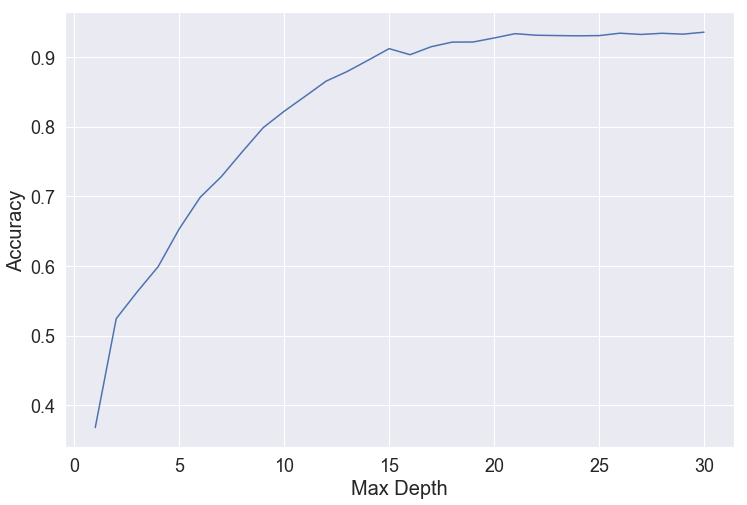

In [53]:
#Create a list to store accuracies of each depth value tested.
accuracies = []

#The following function tests each max_tree depth value from 1-30 five times and averages the accuracy.
def depthTuning(depth):
    acc = []
    for i in range(5):
        train, test = train_test_split(modelData, test_size=.25)

        features = ['total_violations','Type_ Minimum Housing', 'Type_ Multi-Family', 'Type_ Permit Required',
       'Type_ Property Maintenance', 'Type_ Site Work/Utilities',
       'Type_ Unsafe', 'Type_ Vacant Building','GISAcres', 'Just',
       'Assessed', 'Taxable', 'NewBuilt', 'BldgCount',
       'TotalArea', 'HeatedArea', 'MaxStories', 'Bedrooms',
       'Bathrooms', 'Age', 'violationScore']

        model = sktree.DecisionTreeClassifier(max_depth=depth, splitter='best', criterion='entropy')

        model.fit(train[features], train.riskClassification)

        dot_data = StringIO()
        export_graphviz(model, out_file=dot_data,  
                        filled=True, rounded=True,
                        special_characters=True)


        predictedRisk = model.predict(test[features])
        test['predictedRisk'] = predictedRisk
        test.head(10)

        accuracy = accuracy_score(test.riskClassification, predictedRisk)
        acc.append(accuracy)
    return sum(acc)/len(acc)

for d in range(1,31): 
    accuracies.append(depthTuning(d))

#Plot the average accuracy for each max_tree depth value to identify the best one. 
sns.set(rc={'figure.figsize':(12,8)})
rc={'font.size': 20, 'axes.labelsize': 20, 'legend.fontsize': 18, 
    'axes.titlesize': 20, 'xtick.labelsize': 18, 'ytick.labelsize': 18}
sns.set(rc=rc)

plt = pd.DataFrame({'Accuracy':accuracies, 'Max Depth': range(1,31)},)
sns.lineplot(y=plt['Accuracy'], x=plt['Max Depth'], color='b')

## Running the Model on the Idenified Parameters
Now that we identified the best depths to run the model at, we train and test the model at those set parameters. 

In [52]:
train, test = train_test_split(modelData, test_size=.25)

# features = ['GISAcres', 'Just', 'Assessed', 'Taxable', 'Age', 'NewBuilt',
#        'BldgCount', 'TotalArea', 'HeatedArea', 'MaxStories', 'Bedrooms',
#        'Bathrooms','total_violations', 'violationScore']

features = ['total_violations','Type_ Minimum Housing', 'Type_ Multi-Family', 'Type_ Permit Required',
       'Type_ Property Maintenance', 'Type_ Site Work/Utilities',
       'Type_ Unsafe', 'Type_ Vacant Building','GISAcres', 'Just',
       'Assessed', 'Taxable', 'NewBuilt', 'BldgCount',
       'TotalArea', 'HeatedArea', 'MaxStories', 'Bedrooms',
       'Bathrooms', 'Age', 'violationScore']

model = sktree.DecisionTreeClassifier(max_depth=27, criterion='entropy')

model.fit(train[features], train.riskClassification)

dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)


predictedRisk = model.predict(test[features])
test['predictedRisk'] = predictedRisk
test.head(10)

accuracy = accuracy_score(test.riskClassification, predictedRisk)
print("Accuracy: {0:.2%}".format(accuracy))

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

Accuracy: 94.24%


## Feature Importance
Seeing that the model was successful and accurate at predicting risk, we can check to see which features were most inclfuenced risk.

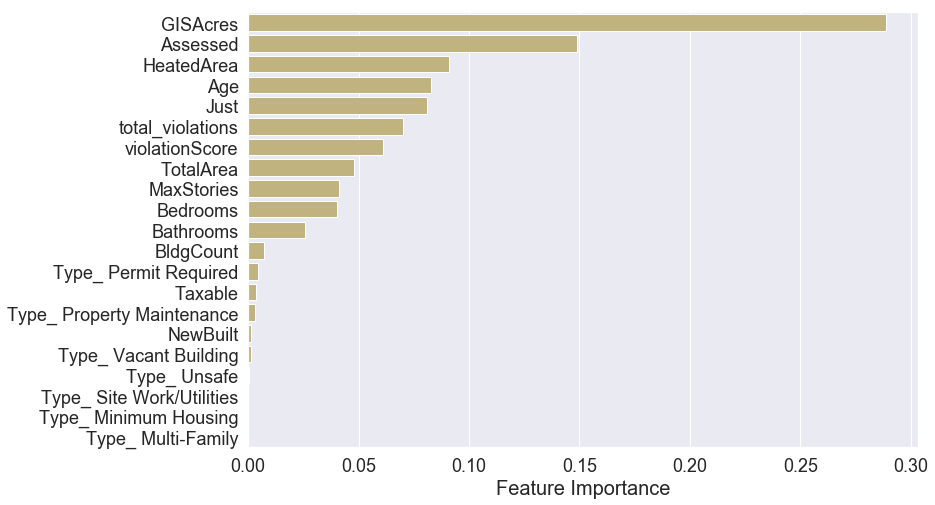

In [54]:
#Graphing the most important features
feat_importance = model.feature_importances_
plt = pd.DataFrame({'Feature Importance':feat_importance},
            index=train.columns[12:35])
plt = plt.sort_values(by='Feature Importance', ascending=False)
sns.barplot(x=plt['Feature Importance'], y=plt.index, color='y')


## Using our Model on Commercial Buildings
Now that we've trained the model on the features above, we can use it to predict commercial and multi-fam buildings' risk scores.

In [55]:
#First we need to generate a dataset of all commercial and multi-fam buildings. 

#mergiing the parcel details with violations data will create a dataframe with the necessary features the model needs to make predictions. 
commercial = pd.merge(cfm, violations, on='Address', how='left')

#Creating a list of all commercial and multi-fam building use descriptions to use to filter our buildings that do not fall in these categories. 
commercialList = ['SHOPPING CENTER, NEIGHBORHOOD', 'OFFICE BUILDING, ONE STORY', 'OFFICE BUILDING, MULTI-STORY', 'AUTO SALES', 'CONVENIENCE STORE', 
              'SANITARIUMS', 'COUNTY OWNED, OFFICES, LIBRARY, GOVERNMENT BLDG', 'VACANT GOVERNMENTAL', 'STORE, ONE (1) FLOOR', 'RESTAURANT', 'MOTEL', 
              'WAREHOUSING', 'MEDICAL OFFICE BUILDING', 'GARAGE, REPAIR', 'FEDERALLY OWNED, OFFICES, LIBRARY, GOVERNMENT BLDG', 'OPEN STORAGE', 'COMMERCIAL, VACANT',
              'GOLF COURSE', 'CONDOMINIUM RESERVE PARCEL', 'SHOPPING CENTER, COMMUNITY', 'RESTAURANT, DRIVE-IN', 'FINANCIAL INSTITUTION', 'PROFESSIONAL BUILDING', 
              'MULTI-FAMILY, 10 OR MORE UNITS', 'MUNICIPALLY OWNED, OFFICES, LIBRARY, GOVERNMENT BLDG', 'DAY CARE CENTERS', 'SCHOOL, PRIVATE', 'LODGES, CLUBS, UNION HALLS', 
              'TOURIST ATTRACTION', 'RETIREMENT HOME', 'LAND CONDO', 'GOVERNMENT OWNED, PUBLIC SCHOOL', 'NONPROFIT SERVICES', 'MULTI-FAMILY, LESS THAN 10 UNITS, RIVER', 
              'VEHICLE LUBE/WASH', 'NIGHT CLUB, BAR, LOUNGE', 'DEPARTMENT STORE', 'AUDITORIUMS, FREESTANDING', 'GOVERNMENT OWNED, PARK', 'SHOPPING CENTER, REGIONAL',
              'STATE OWNED, OFFICES, LIBRARY, GOVERNMENT BLDG', 'UTILITIES', 'LIGHT MANUFACTURING', 'SERVICE SHOP', 'LAUNDROMAT', 'VACANT INSTITUTIONAL', 
              'COUNTRY CLUBS', 'MOBILE HOME SUBDIVISION', 'ACREAGE, BEACH FRONT', 'MINERAL RIGHTS', 'SUBMERGED RIVER', 'APARTMENTS','SERVICE STATION', 'HOTEL', 'CO-OPERATIVE', 
              'MANUFACTURING OFFICES', 'HOME FOR THE AGED, ALF', 'MORTUARY, FUNERAL HOME', 'FLORIST', 'THEATRE', 'SWAMP', 'HEAVY MANUFACTURING', 'MINERAL PROCESSING', 
              'HOSPITAL, PRIVATE', 'LAUNDRY', 'GOVERNMENT OWNED, HOSPITAL', 'DORMITORY', 'MULTI-FAMILY, LESS THAN 10 UNITS, GOLF COURSE', 'FOOD PROCESSING', 
              'CENTRALLY ASSESSED', 'MULTI-FAMILY, LESS THAN 10 UNITS, CANAL', 'BOWLING ALLEY']

#Filtering out all buildings that do not fall in the categories above. 
commercial = commercial[commercial.LandUseDesc.isin(commercialList)]
commercial.violationScore = commercial.violationScore.cat.add_categories([0])
commercial = commercial.fillna(0)
commercial = commercial.drop_duplicates('Address')
commercial.head()

,STRAP_x,FolioID,GISAcres,FireDistDesc,LandUseCode,LandUseDesc,Address,Just,Assessed,Taxable,NewBuilt,BldgCount,MinBuiltYear,MaxBuiltYear,TotalArea,HeatedArea,MaxStories,Bedrooms,Bathrooms,Age,DateCreated,Code,STRAP_y,total_violations,Type_ Minimum Housing,Type_ Multi-Family,Type_ Permit Required,Type_ Property Maintenance,Type_ Site Work/Utilities,Type_ Unsafe,Type_ Vacant Building,violationScore
0,014524P1000600000,10186093.0,6.692,CITY OF FORT MYERS,1610.0,"SHOPPING CENTER, NEIGHBORHOOD",4513/4515 S CLEVELAND AVE,3983962.0,3983962.0,1,0,1.0,1976.0,1976.0,65714.0,52598.0,1.0,0.0,0.0,43.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,014524P1000600020,10186097.0,5.021,CITY OF FORT MYERS,1610.0,"SHOPPING CENTER, NEIGHBORHOOD",2150/2158 COLONIAL BLVD,1179040.0,1179040.0,1,0,3.0,1980.0,1990.0,35972.0,35972.0,1.0,0.0,0.0,34.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,014524P1000600030,10186098.0,3.286,CITY OF FORT MYERS,1700.0,"OFFICE BUILDING, ONE STORY",2160 COLONIAL BLVD,2791137.0,2791137.0,1,0,1.0,1984.0,1984.0,50184.0,43002.0,1.0,0.0,0.0,35.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,014524P100060004A,10186100.0,3.797,CITY OF FORT MYERS,1700.0,"OFFICE BUILDING, ONE STORY",2234 COLONIAL BLVD,3209133.0,3209133.0,1,0,1.0,1993.0,1993.0,34908.0,33068.0,1.0,0.0,0.0,26.0,9/30/16,Permit Required,014524P100060004A,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
5,014524P1000600050,10186101.0,5.129,CITY OF FORT MYERS,1800.0,"OFFICE BUILDING, MULTI-STORY",2270 COLONIAL BLVD,6723394.0,6723394.0,1,0,1.0,2010.0,2010.0,50114.0,48965.0,3.0,0.0,0.0,9.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [56]:
#Let the model predict on the commercial set of buildings
commercial['Predicted Risk Score'] = model.predict(commercial[features])
commercial[['Address', 'Predicted Risk Score']].head()

,Address,Predicted Risk Score
0,4513/4515 S CLEVELAND AVE,7
2,2150/2158 COLONIAL BLVD,8
3,2160 COLONIAL BLVD,7
4,2234 COLONIAL BLVD,6
5,2270 COLONIAL BLVD,5


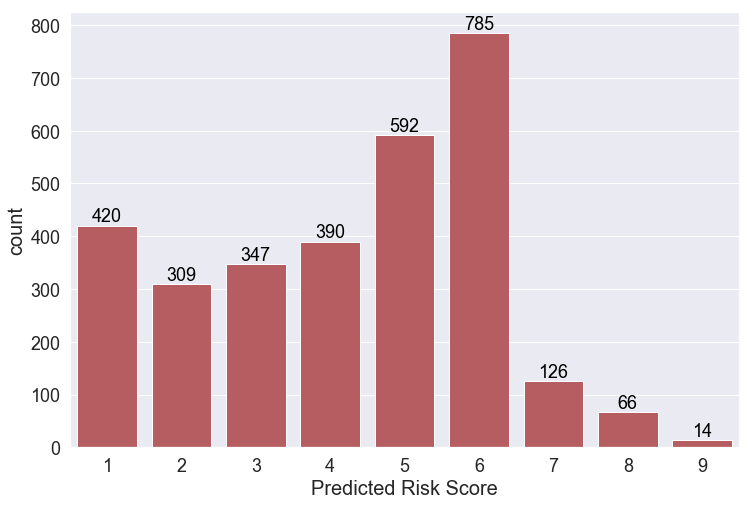

In [57]:
#Graph and visualize the distribution of risk scores
plt = sns.countplot(x='Predicted Risk Score', data=commercial, order=[1,2,3,4,5,6,7,8,9], color='r')
ax = plt
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=18, color='black', ha='center', va='bottom')


Although there are over 5000 commercial buildings in the city, we were only able to identify 3,049 buildings within the data that had sufficient data to predict on. From the figure above we see that there are roughly 950 buildings out of 3000, or close to one third, that are classified as high risk (risk score greater than or equal to 6). 

## Exporting to Excel
We can export these results to an excel spreadsheet that teh FMFD inspectors and firefighters can reference when doing their inspections.

In [58]:
#Including only features that may be useful to inspectors and firefighters
excelExport = commercial[['Address', 'Predicted Risk Score', 'LandUseDesc', 'total_violations', 'GISAcres', 'TotalArea', 'HeatedArea',
       'MaxStories', 'Bedrooms', 'Bathrooms', 'Age','violationScore','STRAP_x', 'STRAP_y', 'FolioID', ]]

#Sorting by highest risk score
excelExport = excelExport.sort_values('Predicted Risk Score', ascending=False)
excelExport = excelExport.set_index('Address')

#exporting to excel spreadsheet
excelExport.to_excel('Commercial and Multi-Fam Buildings and Risk Scores.xlsx')

## Plotting Prediction on an Interactive Map
To allow our users to explore our results we've plotted our predictions on a map of Fort Myers. Green points indicate buildings with risk scores from 0-3, orange are scores 3-6, and red are scores 6-10. The full interactive map can be found here: https://plot.ly/~fortmyersfiredept/2/

In order to edit/update this code, the following need to be obtained: 
Create a Plotly account and generate an API Key: https://plot.ly/python/getting-started/
Create a Mapbox account and get an access token: https://docs.mapbox.com/help/how-mapbox-works/access-tokens/

Copy and paste the keys into the following lines capitalized portions of code below:

In [35]:
#PLOTLY API KEY
PLOTLY_USERNAME = 'YOUR-USERNAME-HERE' 
API_KEY = 'YOUR-API-KEY-HERE'

#MAPBOX ACCESS TOKEN
MAPBOX_TOKEN = 'YOUR-ACCESS-TOKEN-HERE'

In [36]:
#Merge commercial dataset with addresses data to obtain long, lat coordinates
mapping = pd.merge(commercial, adds, on='Address')

#Drop all duplicate addresses
mapData = mapping.drop_duplicates('Address')


In [37]:
#Set plotly credentials to use their mapping library
import plotly 
plotly.tools.set_credentials_file(username=PLOTLY_USERNAME, api_key=API_KEY)
import plotly.plotly as py
import plotly.graph_objs as go
from pandas import Series

mapbox_access_token = MAPBOX_TOKEN

#Text that will display when hovering over each building
mapData['text']  = "RISK SCORE: "+ mapData["Predicted Risk Score"].astype(str) + "<br>ADDRESS: " + mapData.Address +  "<br>USE TYPE: " + mapData.LandUseDesc

mapData['riskMarkerSize'] = pd.cut(mapData['Predicted Risk Score'], [0,3,4,5,6,7,8,9,10] , right=True, include_lowest=True, labels=[8.5,9,9.5,10,10.5,11,12,13])

mapData['riskMarkerColor'] = pd.cut(mapData['Predicted Risk Score'], [0,3,6,10] , right=True, include_lowest=True, labels=['rgb(63,204,104)', 'rgb(255,164,94)', 'rgb(225,0,0)'])

data = [
    go.Scattermapbox(
        lat=Series(mapData.Lat),
        lon=Series(mapData.Long),
        mode='markers',
        
        marker=go.scattermapbox.Marker(
            size=mapData.riskMarkerSize,
            color=mapData.riskMarkerColor
        ),
        text=mapData.text
    )
]

layout = go.Layout(
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=26.625,
            lon=-81.84
        ),
        pitch=0,
        zoom=11.5
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='FMFD Interactive Building Risk Map')


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~fortmyersfiredept/0 or inside your plot.ly account where it is named 'Multiple Mapbox'


#### View Full Interactive Map here: https://plot.ly/~fortmyersfiredept/2